<a href="https://colab.research.google.com/github/SergeevaAlexandra/Classification-of-butterfly-species/blob/main/butterfly_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image, ImageDraw, ImageFont

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf

from tensorflow import keras

from keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.layers import Flatten, Dense, Dropout
from keras.models import Sequential

In [29]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##Dataset Exploration

In [30]:
train_data_path = '/content/drive/MyDrive/dataset_butterfly/train'
# Список всех классов бабочек
butterfly_classes = os.listdir(train_data_path) # строит путь к папке с изображениями для конкретного класса бабочек
print("Butterfly class:", butterfly_classes)

# Количество изображений в каждом классе
for butterfly_class in butterfly_classes:
    class_path = os.path.join(train_data_path, butterfly_class) # os.path.join() нужен для объединения пути с названием класса
    num_images = len(os.listdir(class_path)) # listdir создает массив из названий изображений класса
    print(f"{butterfly_class}: {num_images} images")

Butterfly class: ['Vanessa_cardui', 'Admiral', 'Urticae']
Vanessa_cardui: 220 images
Admiral: 220 images
Urticae: 220 images


In [31]:
test_data_path = '/content/drive/MyDrive/dataset_butterfly/test'

# Список всех классов бабочек
butterfly_classes = os.listdir(test_data_path)
print("Butterfly class:", butterfly_classes)

# Количество изображений в каждом классе
for butterfly_class in butterfly_classes:
    class_path = os.path.join(test_data_path, butterfly_class)
    num_images = len(os.listdir(class_path))
    print(f"{butterfly_class}: {num_images} images")

Butterfly class: ['Admiral', 'Urticae', 'Vanessa_cardui']
Admiral: 30 images
Urticae: 30 images
Vanessa_cardui: 30 images


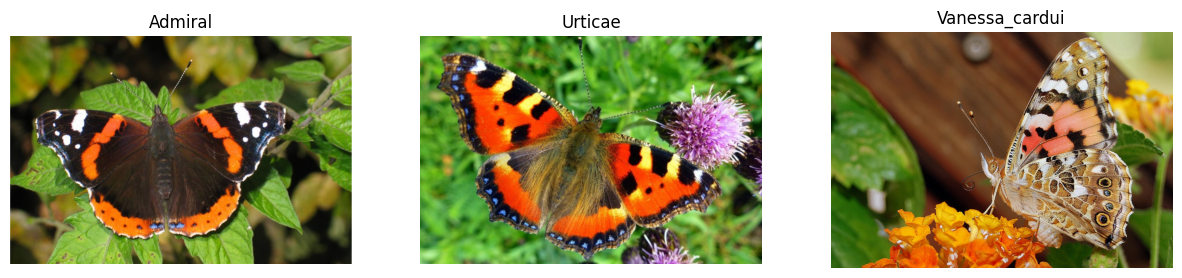

In [32]:
# Выведем изображения из папок с классами
plt.figure(figsize=(15, 15))
for i, butterfly_class in enumerate(butterfly_classes):
    class_path = os.path.join(train_data_path, butterfly_class)
    sample_image_path = os.path.join(class_path, os.listdir(class_path)[1]) # находит путь к одному изображению папки класса

    plt.subplot(1, 3, i+1) # график с сеткой 1x3, выбираем текущую позицию для отображения изображения
    plt.imshow(Image.open(sample_image_path)) # отображает выбранное изображение бабочки
    plt.title(butterfly_class)
    plt.axis('off')

plt.show()

## Data Pre-Processing

Метки для классов:

Admiral - 0

Urticae - 1

Vanessa_cardui - 2

In [33]:
random_seed = 42
test_size = 0.3

# Списки для хранения путей к изображениям и соответствующих меток
all_image_paths, all_labels = [], []


for i, butterfly_class in enumerate(butterfly_classes):
    class_path = os.path.join(train_data_path, butterfly_class)
    class_images = [os.path.join(class_path, image_name) for image_name in os.listdir(class_path)]
    all_image_paths.extend(class_images)
    all_labels.extend([i] * len(class_images))

# Разобьем данные на обучающую и валидационную выборку
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=test_size, random_state=random_seed
)

##Augmentation

In [34]:
datagen = ImageDataGenerator(
    rotation_range=40,         # вращение
    width_shift_range=0.2,     # смещает изображение по направлению оси X
    height_shift_range=0.2,    # смещает изображение по направлению оси Y
    shear_range=0.2,           # степень сдвига
    zoom_range=0.2,            # степень приближения
    horizontal_flip=True       # произвольно повернуть изображение по горизонтали
)

# Преобразование меток в строки
train_labels_str = list(map(str, train_labels))
val_labels_str = list(map(str, val_labels))

# Создаем генератор для обучающей выборки
train_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'path': train_paths, 'label': train_labels_str}),
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse'
)

# Создаем генератор для валидационной выборки
val_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'path': val_paths, 'label': val_labels_str}),
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    shuffle=False
)

Found 460 validated image filenames belonging to 3 classes.
Found 197 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


##Model Training

In [35]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')

# Слои не будут обновляться во время обучения
for l in base_model.layers:
    l.trainable = False

# Создаем последовательную модель поверх предварительно обученной базовой модели
cnn = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(butterfly_classes), activation='softmax')
])

cnn.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics='accuracy')
# Отображает информацию о модели
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 4706982 (17.96 MB)
Trainable params: 657411 (2.51 MB)
Non-trainable params: 4049571 (15.45 MB)
___________

In [36]:
history = cnn.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
8/8 [==============================] - 200s 25s/step - loss: 0.6086 - accuracy: 0.7674 - val_loss: 0.2188 - val_accuracy: 0.9340
Epoch 2/10
8/8 [==============================] - 80s 10s/step - loss: 0.2324 - accuracy: 0.9370 - val_loss: 0.0831 - val_accuracy: 0.9797
Epoch 3/10
8/8 [==============================] - 98s 12s/step - loss: 0.1964 - accuracy: 0.9543 - val_loss: 0.0669 - val_accuracy: 0.9848
Epoch 4/10
8/8 [==============================] - 81s 10s/step - loss: 0.1429 - accuracy: 0.9630 - val_loss: 0.0680 - val_accuracy: 0.9848
Epoch 5/10
8/8 [==============================] - 107s 12s/step - loss: 0.1375 - accuracy: 0.9630 - val_loss: 0.0358 - val_accuracy: 0.9949
Epoch 6/10
8/8 [==============================] - 97s 12s/step - loss: 0.1690 - accuracy: 0.9630 - val_loss: 0.0540 - val_accuracy: 0.9848
Epoch 7/10
8/8 [==============================] - 97s 12s/step - loss: 0.1186 - accuracy: 0.9739 - val_loss: 0.0607 - val_accuracy: 0.9949
Epoch 8/10
8/8 [=========

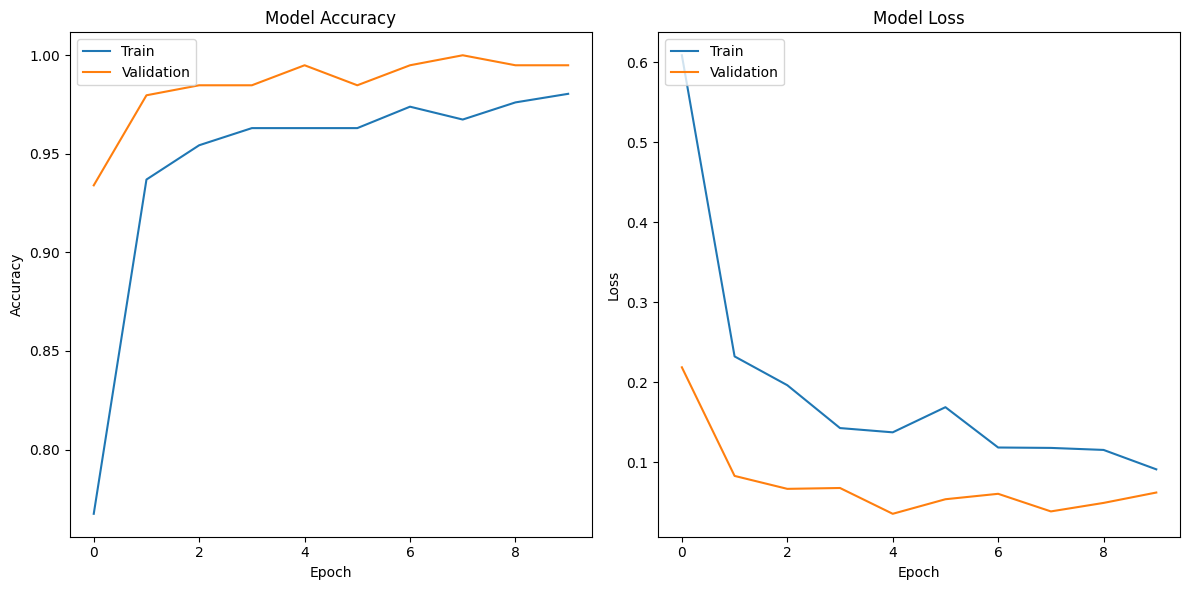

In [37]:
# Визуализируем историю обучения
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [38]:
# Подготовка тестового набора
test_images = []
test_labels_str = []

for butterfly_category in os.listdir(test_data_path):
    category_path = os.path.join(test_data_path, butterfly_category)


    if os.path.isdir(category_path):
        # Проходимся по каждому изображению
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)

            # Проверяем является ли это файлом
            if os.path.isfile(image_path):
                test_images.append(image_path)
                test_labels_str.append(butterfly_category)
# Создайте генератор для тестовых данных без увеличения данных
test_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'path': test_images, 'label': test_labels_str}),
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False,
    augment=False  # Отключает увеличение данных для тестирования
)

# Тестирование модели
# Предсказание на тестовом наборе
test_predictions = cnn.predict(test_generator)

# Преобразует прогнозы в метки классов
predicted_labels = np.argmax(test_predictions, axis=1)

# Сопоставляет предсказанные метки с классами цветов
predicted_classes = [butterfly_classes[label] for label in predicted_labels]

# Отображает некоторые прогнозы
for i in range(min(5, len(test_images))):
    print(f"Test Image: {test_images[i]} - Predicted Class: {predicted_classes[i]}")

Found 90 validated image filenames belonging to 3 classes.
3/3 [==============================] - 37s 14s/step
Test Image: /content/drive/MyDrive/dataset_butterfly/test/Admiral/99fd78d9c8836380773ca49da3937e22.jpeg - Predicted Class: Admiral
Test Image: /content/drive/MyDrive/dataset_butterfly/test/Admiral/162728-babochka-belyi-admiral-34.jpg - Predicted Class: Admiral
Test Image: /content/drive/MyDrive/dataset_butterfly/test/Admiral/68abaace472a33ee60768175fa77119f.jpeg - Predicted Class: Admiral
Test Image: /content/drive/MyDrive/dataset_butterfly/test/Admiral/162728-babochka-belyi-admiral-21.jpg - Predicted Class: Admiral
Test Image: /content/drive/MyDrive/dataset_butterfly/test/Admiral/65456.jpg - Predicted Class: Admiral


In [39]:
# Преобразует истинные метки в числовой формат для оценки
true_labels = [butterfly_classes.index(label) for label in test_labels_str]

# Точность расчета
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2%}")

# Отображение отчета о классификации
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=butterfly_classes))

# Отображает матрицу путаницы
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

Accuracy: 93.33%
Classification Report:
                precision    recall  f1-score   support

       Admiral       0.97      0.93      0.95        30
       Urticae       0.93      0.93      0.93        30
Vanessa_cardui       0.90      0.93      0.92        30

      accuracy                           0.93        90
     macro avg       0.93      0.93      0.93        90
  weighted avg       0.93      0.93      0.93        90

Confusion Matrix:
[[28  0  2]
 [ 1 28  1]
 [ 0  2 28]]


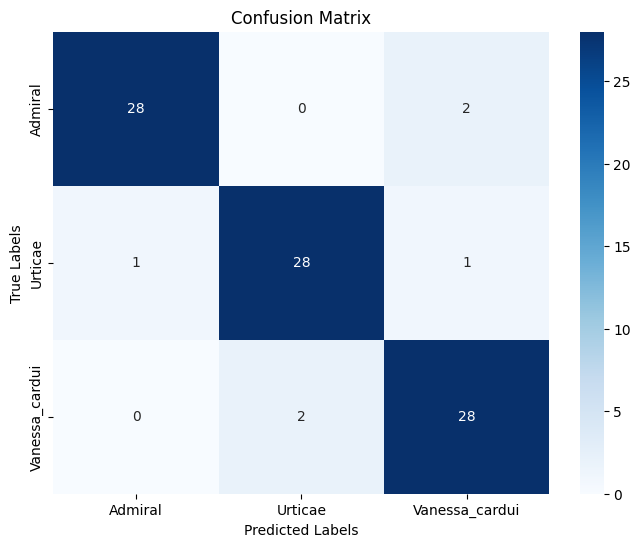

In [40]:
# Визуализирует матрицу путаницы
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True, fmt="d", cmap="Blues", xticklabels=butterfly_classes, yticklabels=butterfly_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()